# Learners
Coba Learners choose which actions to take in a context and learn from results of those actions. The Learner interface is:

```python
class Learner:
    def score(self, context: Context, actions: Sequence[Action], action:Action) -> float:
        """(Optional) Return the propensity score for the given action."""

    def predict(self, context: Context, actions: Sequence[Action]) -> Action | Tuple[Action,float]:
        """Choose which action to take."""
    
    def learn(self, context: Context, action: Action, reward: Reward, probability: float, **kwargs) -> None:
        """Learn from the results of an action in a context.""""
```

The `Context` and `Action` type hints are described in more detail in the [Interactions](Interactions.ipynb) notebook.

## Minimal Viable Learner

To create a custom on-policy learner we implement two methods in the learner interface: `predict` and `learn`. 

As an example here we create a learner that randomly chooses actions without learning anything.

In this example we use Coba's built-in randomization but the random choosing could be implemented using any method.

In [2]:
import coba as cb

class MyRandomLearner:
    def predict(self, context, actions):
        return cb.random.choice(actions)
    def learn(self, context, action, reward, probability):
        pass

And that is all, we can now use this learner in an experiment

2024-02-08 14:30:23 -- Experiment Started
2024-02-08 14:30:23 -- Recording Learner 0 parameters... (0.0 seconds) (completed)
2024-02-08 14:30:23 -- Recording Evaluator 0 parameters... (0.0 seconds) (completed)
2024-02-08 14:30:23 -- Peeking at Environment 0... (0.0 seconds) (completed)
2024-02-08 14:30:23 -- Recording Environment 0 parameters... (0.0 seconds) (completed)
2024-02-08 14:30:23 -- Evaluating Learner 0 on Environment 0... (0.02 seconds) (completed)
2024-02-08 14:30:23 -- Experiment Finished


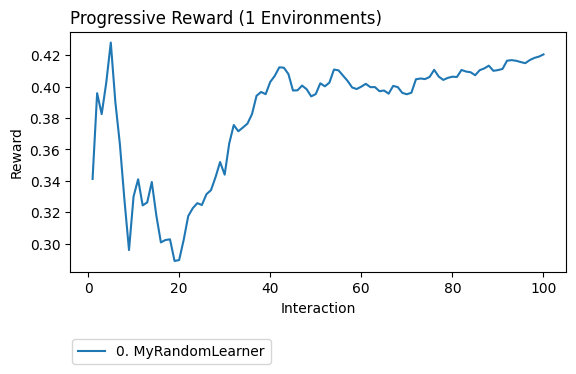

In [13]:
cb.random.seed(1)
env = cb.Environments.from_linear_synthetic(100)
lrn = MyRandomLearner()
cb.Experiment(env,lrn).run().plot_learners()

## Epsilon Bandit Learner

Of course we don't want to just randomly pick actions so here we implement an a bandit learner using epsilon-greedy exploration

In [15]:
import coba as cb

class MyEpsilonBanditLearner:
    def __init__(self, epsilon,seed=1):
        self._epsilon = epsilon
        self._means   = {}
        self._counts  = {}
        self._rng     = cb.CobaRandom(seed)
    
    def predict(self, context, actions):
        if set(actions) - self._means.keys():
            #unseen
            return next(iter(actions-self._means.keys()))
        elif self._rng.random() <= self._epsilon: 
            #explore
            return self._rng.choice(actions)
        else:
            #greed
            return max(actions,key=self._means.__getitem__)
    
    def learn(self, context, action, reward, probability):
        n,m = self._counts.get(action,0),self._means.get(action,0)
        self._counts[action] = n + 1
        self._means[action]  = m + (reward-m)/(n+1)

We can now compare the performance of our epsilon bandit learner to our random learner

2024-02-08 14:31:22 -- Experiment Started
2024-02-08 14:31:22 -- Recording Learner 0 parameters... (0.0 seconds) (completed)
2024-02-08 14:31:22 -- Recording Evaluator 0 parameters... (0.0 seconds) (completed)
2024-02-08 14:31:22 -- Recording Learner 1 parameters... (0.0 seconds) (completed)
2024-02-08 14:31:22 -- Peeking at Environment 0... (0.0 seconds) (completed)
2024-02-08 14:31:22 -- Recording Environment 0 parameters... (0.0 seconds) (completed)
2024-02-08 14:31:23 -- Evaluating Learner 0 on Environment 0... (0.0 seconds) (completed)
2024-02-08 14:31:23 -- Evaluating Learner 1 on Environment 0... (0.0 seconds) (completed)
2024-02-08 14:31:23 -- Experiment Finished


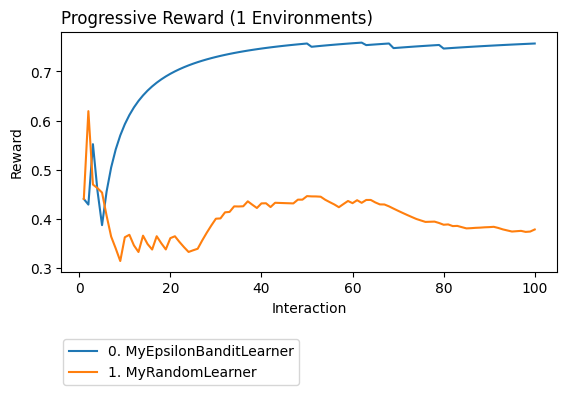

In [24]:
cb.random.seed(4)
env = cb.Environments.from_linear_synthetic(100,n_context_features=0,n_action_features=0)
lrn = [MyEpsilonBanditLearner(.1), MyRandomLearner()]
cb.Experiment(env,lrn).run().plot_learners()

## Learner Parameters

To understand what makes our learner work it is useful to keep track of learner parameters. Here we add to our bandit learner.

In [25]:
import coba as cb
#The super class MyEpsilonBanditLearner is defined above
class MyEpsilonBanditLearnerWithParams(MyEpsilonBanditLearner):
    @property
    def params(self):
        return {'epsilon': self._epsilon}

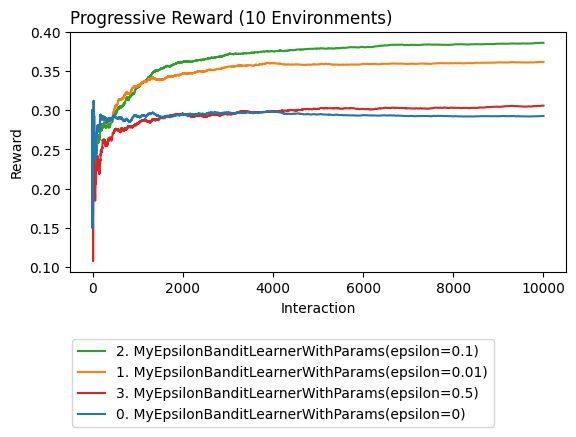

In [26]:
env = cb.Environments.from_linear_synthetic(10_000,n_context_features=0,n_action_features=0,seed=range(10)).noise(reward=(0,.5)).binary()
lrn = [ MyEpsilonBanditLearnerWithParams(e) for e in [0,.01,.1,.5] ]
cb.Experiment(env,lrn).run(quiet=True,processes=8).plot_learners()

## Recording Probabilities

It can be useful to keep track of the probability of taking actions for this use case probabilities can be returned with actions.

When probabilities are returned from `predict` the probability will be passed to `learn` as the `probability` arg.

In [1]:
import coba as cb

class MyRandomLearnerWithProbabilities:
    def predict(self, context, actions):
        probability = 1/len(actions)
        chosen_act  = cb.random.choice(actions)
        return chosen_act, probability
        
    def learn(self, context, action, reward, probability):
        #When this is called probability equals the probability returned from predict
        pass

See below that we have the probabilities from our learner stored in result.

In [8]:
env = cb.Environments.from_linear_synthetic(4,n_action_features=0)
lrn = MyRandomLearnerWithProbabilities()
result = cb.Experiment(env,lrn).run(quiet=True)
result.interactions.to_pandas()

,environment_id,learner_id,evaluator_id,index,action,probability,reward
0,0,0,0,1,"[0, 1, 0, 0, 0]",0.2,0.52699
1,0,0,0,2,"[0, 1, 0, 0, 0]",0.2,0.56189
2,0,0,0,3,"[0, 1, 0, 0, 0]",0.2,0.48935
3,0,0,0,4,"[1, 0, 0, 0, 0]",0.2,0.53100


## Custom Arguments

Some learners require additional information to be shared between `predict` and `learn`. 

For this use case we support explicitly returning kwargs.


In [6]:
import coba as cb

class MyRandomLearnerWithKwargs:

    def predict(self, context, actions):
        probability = 1/len(actions)
        chosen_act  = cb.random.choice(actions)
        kwargs      = {'kwarg1' : 1, 'item1': 2, 'b': 3}
        return chosen_act, probability, kwargs

    def learn(self, context, action, reward, probability, kwarg1, item1, b):
        pass

## Score Method

The score method is largely optional. When it is implemented it used in the following ways:
1. It is optional to reduce the variance of IPS off-policy evaluation for discrete action spaces.
2. It is required to perform IPS off-policy evaluation in continuous action spaces.
3. It is required to use the RejectionCB evaluator due to rejection sampling.

In [8]:
import coba as cb

class MyRandomLearnerWithProbabilities:

    def score(self, context, actions, action):
        #this should return the probability of taking `action`
        #given context and actions. In discrete settings action
        #should always be in actions.
        return 1/len(actions)
        
    def predict(self, context, actions):
        probability = 1/len(actions)
        chosen_act  = cb.random.choice(actions)
        return chosen_act, probability

    def learn(self, context, action, reward, probability):
        pass

## Advanced Metrics

Coba's built-in evaluators can track all desired metric for learners using the dictionary at `CobaContext.learning_info`.

Below we show how to track the current estimated mean for each action as a bandit learner gets observations.

In [11]:
import coba as cb

#The super class MyEpsilonBanditLearner is defined above
class MyEpsilonBanditLearnerWithMetrics(MyEpsilonBanditLearner):
    def learn(self,*args):
        super().learn(*args)
        cb.CobaContext.learning_info.update(self._means)

In [12]:
env = cb.Environments.from_linear_synthetic(8,n_context_features=0,n_action_features=0,n_actions=2).noise(reward=(0,0.5)).binary()
lrn = MyEpsilonBanditLearnerWithMetrics(.5)
result = cb.Experiment(env,lrn).run(quiet=True)
result.interactions.to_pandas()

,environment_id,learner_id,evaluator_id,index,"(0, 1)","(1, 0)",action,reward
0,0,0,0,1,NaN,1.00000,"[1, 0]",1
1,0,0,0,2,1.00000,1.00000,"[0, 1]",1
2,0,0,0,3,1.00000,1.00000,"[0, 1]",1
3,0,0,0,4,1.00000,0.50000,"[1, 0]",0
4,0,0,0,5,0.66667,0.50000,"[0, 1]",0
5,0,0,0,6,0.66667,0.33333,"[1, 0]",0
6,0,0,0,7,0.75000,0.33333,"[0, 1]",1
7,0,0,0,8,0.75000,0.50000,"[1, 0]",1
